In [7]:
import openmdao
print('OpenMDAO version:', openmdao.__version__)
assert int(openmdao.__version__[0]) == 2, "OpenMDAO version should be 2!"

OpenMDAO version: 2.2.0


In [139]:
from openmdao.api import Problem, ScipyOptimizeDriver, ExecComp, IndepVarComp

# build the model
prob = Problem()
indeps = prob.model.add_subsystem('indeps', IndepVarComp())
indeps.add_output('x', 3.0)
indeps.add_output('y', -4.0)

prob.model.add_subsystem('paraboloid', ExecComp('f = (x-3)**2 + x*y + (y+4)**2 - 3'))

prob.model.connect('indeps.x', 'paraboloid.x')
prob.model.connect('indeps.y', 'paraboloid.y')

# setup the optimization
prob.driver = ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'

prob.model.add_design_var('indeps.x', lower=-50, upper=50)
prob.model.add_design_var('indeps.y', lower=-50, upper=50)
prob.model.add_objective('paraboloid.f')
prob.driver.add_recorder

prob.setup()
prob.run_driver()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -27.333333333333336
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 5
Optimization Complete
-----------------------------------


False

##### Paraboloid function

$f(x,y) = (x-3)^2 + x y + (y+4)^2 - 3$

In [15]:
f = lambda x, y: (x-3)**2 + x*y + (y+4)**2 - 3

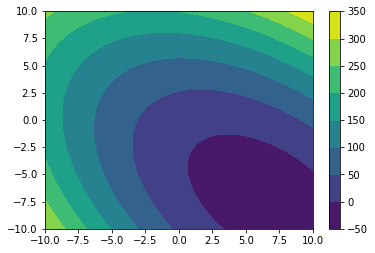

In [89]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

delta = 0.025
x = np.arange(-10.0, 10.0, delta)
y = np.arange(-10.0, 10.0, delta)
X, Y = np.meshgrid(x, y)
Z = f(X,Y)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
CS = ax.contourf(X, Y, Z)
fig.colorbar(CS);

##### minimum value

In [86]:
print(prob['paraboloid.f'])

[-27.33333333]


##### location of the minimum

In [87]:
min_x = prob['indeps.x'][0]
print('Minimum X:', min_x)

min_y = prob['indeps.y'][0]
print('Minimum Y:', min_y)

Minimum X: 6.666666666666667
Minimum Y: -7.333333333333333


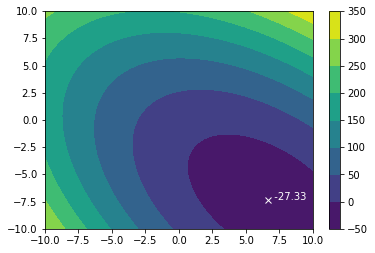

In [88]:
ax.plot(min_x, min_y, 'xw')
ax.text(min_x, min_y, "  {0:.2f}".format(prob['paraboloid.f'][0]), color='w')
fig

## OpenMDAO Elements 

### Components



#### The Three Types of Components


In our numerical model, we have three variables: $x$, $y$, and $z$.
Each of these variables needs to be defined as the output of a component.
There are three basic types of components in OpenMDAO:


1. `IndepVarComp` : defines independent variables (e.g., x)
2. `ExplicitComponent`: defines dependent variables that are computed explicitly (e.g., z)
3. `ImplicitComponent` : defines dependent variables that are computed implicitly (e.g., y)


The most straightforward way to implement the numerical model would be to assign each variable its own component, as below.

```
  ===  =================  =======  =======
  No.  Component type     Inputs   Outputs
  ===  =================  =======  =======
   1   IndepVarComp                   x
   2   ImplicitComponent    x, z      y
   3   ExplicitComponent     y        z
  ===  =================  =======  =======
```



In [106]:
from openmdao.api import ExplicitComponent

class Paraboloid(ExplicitComponent):
    

    def setup(self):
        self.add_input('x', val=0.0)
        self.add_input('y', val=0.0)

        self.add_output('f', val=0.0)

        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        
        x = inputs['x']
        y = inputs['y']

        outputs['f'] = (x-3)**2 + x*y + (y+4)**2 - 3

### Problem

<img src="http://openmdao.org/twodocs/versions/2.0.0/_images/problem_diagram.png" width="600">

In [135]:

# build the model
prob = Problem()
indeps = prob.model.add_subsystem('indeps', IndepVarComp())
indeps.add_output('x', 3.0)
indeps.add_output('y', -4.0)

#prob.model.add_subsystem('paraboloid', ExecComp('f = (x-3)**2 + x*y + (y+4)**2 - 3'))
prob.model.add_subsystem('paraboloid', Paraboloid())

prob.model.connect('indeps.x', 'paraboloid.x')
prob.model.connect('indeps.y', 'paraboloid.y')

# setup the optimization
prob.driver = ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'

prob.model.add_design_var('indeps.x', lower=-50, upper=50)
prob.model.add_design_var('indeps.y', lower=-50, upper=50)
prob.model.add_objective('paraboloid.f')

prob.setup()
prob.run_driver()


# minimum value
print(prob['paraboloid.f'])
# location of the minimum
print(prob['paraboloid.x'])
print(prob['paraboloid.y'])

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -27.333333333333
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 5
Optimization Complete
-----------------------------------
[-27.33333333]
[6.66666633]
[-7.33333367]


#### Let's add a constraint to this optimization

$g = x + y \in [0,10]$

In [137]:
# define the component whos output will be constrained
prob.model.add_subsystem('const', ExecComp('g = x + y'))

prob.model.connect('indeps.x', ['const.x'])
prob.model.connect('indeps.y', ['const.y'])

# to add the constraint to the model
prob.model.add_constraint('const.g', lower=0, upper=10.)
#prob.model.add_constraint('const.g', equals=0.)

RuntimeError: Subsystem name 'const' is already used.

In [138]:
prob.setup()
prob.run_driver()
# minimum value
print(prob['paraboloid.f'])
# location of the minimum
print(prob['indeps.x'])
print(prob['indeps.y'])

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -27.0
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization Complete
-----------------------------------
[-27.]
[7.]
[-7.]
